<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/model-v0/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [1]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9417c25e3d3674831d61f795ff10635d04020a765892b9f2cc0a55924d2ee7ac
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

## Libraries

In [1]:
# LIBRARIES

import os
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, pipeline
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge')

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-1-886710a53c25>:34: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

## Logins, Paths and Auxiliar Functions

In [3]:
# Connect w/ HuggingFace HUB
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
# PATHS

BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/"
save_path = BASE_PATH + '/Results/TLDR/BART/model-v0/'

documents = os.listdir(BASE_PATH)

In [3]:
# AUXILIAR FUNCTIONS

# Function to convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell



# Function to join all the sentences of input document
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data




# Define the metric to use (ROUGE Scores)
def metric_fn(eval_predictions):
  predictions, labels = eval_predictions
  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )

  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

## Preprocess Data

In [4]:
data = pd.read_csv(BASE_PATH+'Data/Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.sample(5)

,source,paper_id,target,title,number_words_target,extractive_summary
892,Several recent works have developed methods fo...,BygANhA9tQ,A general method for training certified cost-s...,Cost-Sensitive Robustness against Adversarial ...,72,We encode the potential harm of each adversari...
1067,For many evaluation metrics commonly used as b...,HkxKH2AcFm,We argue that GAN benchmarks must require a la...,Towards GAN Benchmarks Which Require Generaliz...,40,We clarify a necessary condition for an evalua...
222,Data augmentation is commonly used to encode i...,Byxpfh0cFm,Selectively augmenting difficult to classify p...,Efficient Augmentation via Data Subsampling,72,Data augmentation is also a popular technique ...
109,The use of deep learning models as priors for ...,Hyleh7hqUH,Improved a GAN based pixel inpainting network ...,NaN,32,"Along these lines, a compressive sensing desig..."
386,Model-based reinforcement learning has been em...,B1gskyStwr,Acquire states from high frequency region for ...,Frequency-based Search-control in Dyna,42,We develop a simple strategy to locally measur...


In [5]:
# Count number of words of source and target
def count_words(column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words('target')
data['number_words_source'] = count_words('source')
data['number_words_extractive'] = count_words('extractive_summary')

In [6]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    1312.000000
mean       58.935213
std        20.402388
min        30.000000
25%        41.000000
50%        58.000000
75%        73.000000
max       149.000000
Name: number_words_target, dtype: float64
count     1312.000000
mean      5177.437500
std       2107.094236
min        126.000000
25%       4069.750000
50%       5001.500000
75%       6187.750000
max      24589.000000
Name: number_words_source, dtype: float64
count    1312.000000
mean      621.176067
std       143.951058
min       126.000000
25%       534.000000
50%       611.000000
75%       693.000000
max      1199.000000
Name: number_words_extractive, dtype: float64


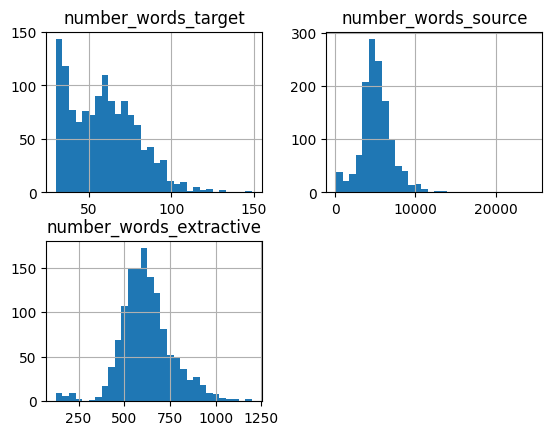

In [7]:
# Histogramas
data.hist(bins=30)
plt.show()

In [8]:
data = data[data['number_words_target']>=40].reset_index(drop=True)
data['number_words_target'].describe()

count    1012.000000
mean       66.381423
std        17.169049
min        40.000000
25%        54.000000
50%        64.000000
75%        77.000000
max       149.000000
Name: number_words_target, dtype: float64

In [9]:
data = data[:100]

## BART



#### Prepare Data for Model

In [10]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        random_state=42)

In [11]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(64, 8) (16, 8) (80, 8) (20, 8)


In [12]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

In [13]:
# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [14]:
# Tokenize data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
tokenized_data = raw_data.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

#### Model

In [83]:
# Load BART Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

model.generation_config.max_length = 150
# model.generation_config.min_length = 50
model.generation_config.length_penalty = 2
model.generation_config.num_beams = 4

model.generation_config.do_sample = True
model.generation_config.temperature = 0.5

model.config.attention_dropout = 0.2

print(model.generation_config)

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 140,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "temperature": 0.5
}



In [84]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

In [85]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [86]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [87]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(2):  # Take the first batch for inspection
    print(batch)

({'input_ids': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[    0,   170,   617, ...,     1,     1,     1],
       [    0, 39936,  1844, ...,     1,     1,     1],
       [    0, 16713, 25376, ...,     1,     1,     1],
       ...,
       [    0,  1121,  1989, ...,     1,     1,     1],
       [    0,   170,  2807, ...,     1,     1,     1],
       [    0,  1121,    42, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'decoder_input_ids': <tf.Tensor: shape=(8, 120), dtype=int64, numpy=
array([[    2,     0,   170,  1950, 24934,  2072,     5,  5428, 22098,
            7,   290,    12,  5881,     8,  1477, 19850,  1318,  1118,
            7,     5,   455, 15339,  1421,     4,   660,   290,    12,
         5881, 24934,  1938, 

In [88]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [89]:
BASE_PATH

'/content/drive/MyDrive/VIU/TFM/Desarrollo/'

In [90]:
checkpoint_path = BASE_PATH + '/Results/TLDR/BART/model_save/checkpoint'
os.makedirs(checkpoint_path, exist_ok=True)

In [91]:
BART_PATH = BASE_PATH + '/Results/TLDR/BART'

#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True
)

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./model_save",
#     tokenizer=tokenizer,
#     hub_model_id="iguerrasevillano/BART-summ-v1",
#     save_strategy='epoch',
#     checkpoint=True
# )


# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_path+"/weights.h5",
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=True,
#     mode='min',
# )

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [92]:
resume = False
epochs = 4

callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early]
            #  checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

[INFO: fine-tuning model...]
Epoch 1/4
8/8 [==============================] - 464s 59s/step - loss: 4.1905 - val_loss: 3.6375 - rouge1: 32.8287 - rouge2: 7.1650 - rougeL: 19.5207 - rougeLsum: 28.0513 - gen_len: 135.6875
Epoch 2/4
8/8 [==============================] - 413s 57s/step - loss: 3.6908 - val_loss: 3.5737 - rouge1: 34.3806 - rouge2: 8.8375 - rougeL: 22.7469 - rougeLsum: 29.2809 - gen_len: 61.9375
Epoch 3/4
8/8 [==============================] - 355s 49s/step - loss: 3.4707 - val_loss: 3.5186 - rouge1: 36.1894 - rouge2: 9.9803 - rougeL: 22.9099 - rougeLsum: 31.7749 - gen_len: 80.6250
Epoch 4/4
8/8 [==============================] - 333s 46s/step - loss: 3.2901 - val_loss: 3.5295 - rouge1: 37.3246 - rouge2: 9.8269 - rougeL: 22.8201 - rougeLsum: 31.9708 - gen_len: 80.8750


In [ ]:
# Save the model and tokenizer to a directory
save_path = BASE_PATH + '/Results/TLDR/BART/model-v0/'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

In [ ]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    plt.legend()

plot_graphics(H)

### Si quiero recargar modelo

In [19]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(save_path)
tokenizer = BartTokenizer.from_pretrained(save_path)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model-v0/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [81]:
print('[INFO]: generating tests summaries...')
generated_ids = model.generate([tokenized_data['test']['input_ids'][3]])
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

[INFO]: generating tests summaries...


['We propose a hybrid attention architecture for Chinese text classification. This paper proposes an attention architecture that combines Pinyin encoder and word encoder to solve the pronunciation expression problem. The paper proposes a new attention architecture to address pronunciation expression problems in Chinese texts.']

In [97]:
print('[INFO]: generating tests summaries...')
generated_ids = model.generate([tokenized_data['test']['input_ids'][11]])
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

[INFO]: generating tests summaries...


['We introduce skip connections between adjacent layers to model degeneracy and training difficulty. This paper proposes a model with a hyper-residual linear residual architecture that introduces skip connections to the input layer. The authors propose a model of linear residual networks with skip connections, and propose a method to reduce the loss landscape of nonlinear residual networks.']

In [96]:
tokenized_data['test']['target'][11]

'Degenerate manifolds arising from the non-identifiability of the model slow down learning in deep networks; skip connections help by breaking degeneracies. The authors show that elimination singularities and overlap singularities impede learning in deep neural networks, and demonstrate that skip connections can reduce the prevalence of these singularities, speeding up learning. Paper examines the use of skip connections in deep networks as a way of alleviating singularities in the Hessian matrix during training.'

In [79]:
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[2]

IndexError: list index out of range

In [138]:
# Fine-tuned model Test
predicted_labels = np.array(generated_ids)
reference_labels = np.array(tokenized_data['test']['labels'])

metric_fn((predicted_labels, reference_labels))

{'rouge1': 32.34354232483341,
 'rouge2': 10.579777008718464,
 'rougeL': 24.41126671125156,
 'rougeLsum': 24.664965912940556,
 'gen_len': 41.25}

In [141]:
model.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 3,
  "max_new_tokens": 80,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

In [144]:
# Pretrained model Test (check how results have improved)
pretrained_model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

pretrained_model.generation_config.max_new_tokens = model.generation_config.max_new_tokens
pretrained_model.generation_config.length_penalty = model.generation_config.length_penalty


pretrained_generated_ids = pretrained_model.generate(tokenized_data['test']['input_ids'])
pretrained_predicted_labels = np.array(pretrained_generated_ids)

metric_fn((pretrained_predicted_labels, reference_labels))

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 15.611755054050452,
 'rouge2': 3.519979513900487,
 'rougeL': 12.288732891223875,
 'rougeLsum': 12.41976755747476,
 'gen_len': 20.0}

In [151]:
i = 6
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:OE teaches anomaly detectors to learn heuristics for detecting unseen anomalies; experiments are in classification, density estimation, and calibration in NLP and vision settings; we do not tune on test distribution samples, unlike previous work
FINE TUNED MODEL:Outlier Exposure improves the calibration of neural network classifiers in the realistic setting where a fraction of the data is OOD. We show that Outlier Exposure can improve calibration performance in this realistic setting.
PRETRAINED MODEL:However, when there is a distribution mismatch, deep neural network classifiers tend to give


In [153]:
data['extractive_summary'][10]

'In particular, (Santurkar et al., 2018) recently studied the mode collapsing problem and further classified this into the missing mode problem i.e., the generated samples miss some modes in the true data, and the boundary distortion problem i.e., the generated samples can only partly recover some modes in the true data. To handle sequential data in the context of domain adaptation of software vulnerability detection, the work of proposed an architecture referred to as the Code Domain Adaptation Network (CDAN). A fully connected layer is then employed to connect the output layer of the Bidirectional RNN with the joint feature layer while bridging the gap between the source and target domains. In particular, (Santurkar et al., 2018) has recently studied the mode collapsing problem of GANs and discovered that they are also subject to i) the missing mode problem (i.e., in the joint space, either the target data misses some modes in the source data or vice versa) and ii) the boundary disto